In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/language_classification

/content/drive/MyDrive/language_classification


In [ ]:
%ls

data/  Run_Script.ipynb


# Import libraries

In [ ]:
import os
import sys
import glob
import time
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
#from torch.utils.tensorboard import SummaryWriter
#from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import unicodedata
import string
import copy

# 1. Load data

In [ ]:
data_folder = os.path.join("data", "names")
paths = glob.glob(os.path.join(data_folder, "*.txt"))
print(paths)

['data/names/Dutch.txt', 'data/names/Czech.txt', 'data/names/German.txt', 'data/names/Greek.txt', 'data/names/Chinese.txt', 'data/names/Spanish.txt', 'data/names/Russian.txt', 'data/names/Arabic.txt', 'data/names/Scottish.txt', 'data/names/English.txt', 'data/names/Portuguese.txt', 'data/names/Korean.txt', 'data/names/Vietnamese.txt', 'data/names/Japanese.txt', 'data/names/French.txt', 'data/names/Italian.txt', 'data/names/Polish.txt', 'data/names/Irish.txt']


Load every word into a dictionary with language as its key.

In [ ]:
language_dict = {}
for path in paths:
  language = path.split("/")[2][:-4]
  with open(path, "r") as f :
    words = f.readlines()
    words_list = [word.strip().lower() for word in words]
    language_dict[language] = words_list

In [ ]:
deleted_language = []
for language, words in language_dict.items():
  print(language, len(words))
  if len(words) < 200:
    deleted_language.append(language)

Dutch 297
Czech 519
German 724
Greek 203
Chinese 268
Spanish 298
Russian 9408
Arabic 2000
Scottish 100
English 3668
Portuguese 74
Korean 94
Vietnamese 73
Japanese 991
French 277
Italian 709
Polish 139
Irish 232


Remove the language which has few input so it can't damper our model input.

In [ ]:
for language in deleted_language:
  del language_dict[language]
for language, words in language_dict.items():
  print(language, len(words))

Dutch 297
Czech 519
German 724
Greek 203
Chinese 268
Spanish 298
Russian 9408
Arabic 2000
English 3668
Japanese 991
French 277
Italian 709
Irish 232


# 2. Create a list for every character in every language

In [ ]:
characters = set()
for language, words in language_dict.items():
  for word in words:
    characters.update(list(word))
characters = sorted(list(characters))
print(characters)

[' ', "'", ',', '-', '/', '1', ':', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\xa0', 'ß', 'à', 'á', 'ä', 'ç', 'è', 'é', 'ê', 'ì', 'í', 'ñ', 'ò', 'ó', 'ö', 'ù', 'ú', 'ü']


# 3. Create hash tables for languages and characters

In [ ]:
num_langs = len(language_dict.keys())
num_chars = len(characters)
print(num_langs, num_chars)

13 51


In [ ]:
language_to_num = {a:x for a, x in zip(sorted(list(language_dict.keys())), range(num_langs))}

print(language_to_num)

{'Arabic': 0, 'Chinese': 1, 'Czech': 2, 'Dutch': 3, 'English': 4, 'French': 5, 'German': 6, 'Greek': 7, 'Irish': 8, 'Italian': 9, 'Japanese': 10, 'Russian': 11, 'Spanish': 12}


In [ ]:
character_to_num = {a:x for a, x in zip(characters, range(num_chars))}

print(character_to_num)

{' ': 0, "'": 1, ',': 2, '-': 3, '/': 4, '1': 5, ':': 6, 'a': 7, 'b': 8, 'c': 9, 'd': 10, 'e': 11, 'f': 12, 'g': 13, 'h': 14, 'i': 15, 'j': 16, 'k': 17, 'l': 18, 'm': 19, 'n': 20, 'o': 21, 'p': 22, 'q': 23, 'r': 24, 's': 25, 't': 26, 'u': 27, 'v': 28, 'w': 29, 'x': 30, 'y': 31, 'z': 32, '\xa0': 33, 'ß': 34, 'à': 35, 'á': 36, 'ä': 37, 'ç': 38, 'è': 39, 'é': 40, 'ê': 41, 'ì': 42, 'í': 43, 'ñ': 44, 'ò': 45, 'ó': 46, 'ö': 47, 'ù': 48, 'ú': 49, 'ü': 50}


# 4. Split data

In [ ]:
words_df = []
for language, words in tqdm(language_dict.items()):
  for word in words:
    words_df.append({"word":word, "language":language})
words_df = pd.DataFrame(words_df)
print(words_df.shape)
words_df.head()

  0%|          | 0/13 [00:00<?, ?it/s]

(19594, 2)


,word,language
0,aalsburg,Dutch
1,aalst,Dutch
2,aarle,Dutch
3,achteren,Dutch
4,achthoven,Dutch


In [ ]:
train_df, test_df = train_test_split(words_df, train_size=0.8, stratify=words_df["language"], random_state=0)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
print(train_df.shape, test_df.shape)

(15675, 2) (3919, 2)


In [ ]:
train_count = train_df['language'].value_counts().rename("Train")
test_count = test_df['language'].value_counts().rename("Test")
count = pd.concat([train_count, test_count], axis=1, sort=True).T
count.loc["Total", :] = count.sum(axis=0) #add new row
count.loc[:, "Total"] = count.sum(axis=1) #add new column
count = count.astype("int")

count

language,Arabic,Chinese,Czech,Dutch,English,French,German,Greek,Irish,Italian,Japanese,Russian,Spanish,Total
Train,1600,214,415,238,2934,222,579,163,186,567,793,7526,238,15675
Test,400,54,104,59,734,55,145,40,46,142,198,1882,60,3919
Total,2000,268,519,297,3668,277,724,203,232,709,991,9408,298,19594


# 5. Create dataset

In [ ]:
max_step = 0
for _, words in language_dict.items():
  for word in words:
    if len(word) > max_step:
      max_step = len(word)
print(max_step)

20


In [ ]:
class LangDataset(Dataset):


  def __init__(self, words_df):
    self.words_df = words_df

  def __len__(self):
    self.len = len(self.words_df)
    return self.len
  # def __getitem__(self, index) -> _T_co:
  #   return super().__getitem__(index)

  def __getitem__(self, index):
    row = self.words_df.iloc[index, :]
    word = row['word'].ljust(max_step)
    x = torch.zeros((max_step, num_chars))
    for i, char in enumerate(word):
      x[i, character_to_num[char]] = 1

    y = language_to_num[row['language']]
    return x, y


training_set = LangDataset(train_df)
testing_set = LangDataset(test_df)

# 6. Create dataloader

In [ ]:
train_batch_size = 128
test_batch_size = 4

In [ ]:
train_loader = DataLoader(training_set, batch_size=train_batch_size, shuffle=True, num_workers=os.cpu_count())
test_loader = DataLoader(testing_set, batch_size=test_batch_size, shuffle=False, num_workers=os.cpu_count())


In [ ]:
data_iter = iter(train_loader)
X, Y = next(data_iter)
print(X.shape, Y.shape)
print(X, Y)

torch.Size([128, 20, 51]) torch.Size([128])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 0., 0

# 7. Create Pytorch model

In [ ]:
hidden_size = 24
num_layers = 2

device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


In [ ]:
class Model(nn.Module):

  def __init__(self, input_size, output_size, hidden_size, num_layers):
    super(Model, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
    self.fc2 = nn.Linear(in_features=hidden_size, out_features=output_size)

  def forward(self, X):
    batch_size = X.size(0)
    h0 = torch.randn((self.num_layers, batch_size, self.hidden_size)).to(device)
    c0 = torch.randn((self.num_layers, batch_size, self.hidden_size)).to(device)
    out, ht = self.lstm1(X, (h0, c0))
    outn = out[:, -1, :]
    outn = outn.contiguous().view(batch_size, self.hidden_size)
    outn = self.fc2(outn)
    return outn

In [ ]:
model = Model(input_size=num_chars, output_size=num_langs, hidden_size=hidden_size, num_layers=num_layers)
model = nn.DataParallel(model)
model = model.to(device)
print(model)

DataParallel(
  (module): Model(
    (lstm1): LSTM(51, 24, num_layers=2, batch_first=True)
    (fc2): Linear(in_features=24, out_features=13, bias=True)
  )
)


# 8. Configure parameters

In [ ]:
lr = 0.01
step_size = len(train_loader) *4
gamma = 0.95
print(step_size)

492


In [ ]:
alpha = 0.6
weights = len(train_df) / (train_df['language'].value_counts() ** alpha)
weights = weights / weights.sum()
weights = weights.sort_index()
print(weights)

language
Arabic      0.033303
Chinese     0.111354
Czech       0.074839
Dutch       0.104474
English     0.023146
French      0.108929
German      0.061284
Greek       0.131112
Irish       0.121129
Italian     0.062059
Japanese    0.050745
Russian     0.013153
Spanish     0.104474
Name: count, dtype: float64


In [ ]:
weights = torch.Tensor(weights).to(device)
print(weights)

tensor([0.0333, 0.1114, 0.0748, 0.1045, 0.0231, 0.1089, 0.0613, 0.1311, 0.1211,
        0.0621, 0.0507, 0.0132, 0.1045], device='cuda:0')


<ipython-input-341-8e2ee92f689c>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  weights = torch.Tensor(weights).to(device)


In [ ]:
criterion = nn.CrossEntropyLoss(weight=weights, reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=lr)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=step_size, gamma=gamma)

# 9.Train model

In [ ]:
epochs = 100

epoch_losses = []
epoch_lrs = []
iteration_losses = []
iteration_lrs = []

for epoch in tqdm(range(1, epochs + 1)):
  epoch_loss = 0
  epoch_lr = 0
  for X, Y in tqdm(train_loader, desc="Epoch-{}".format(epoch)):
    X, Y = X.to(device), Y.to(device)
    optimizer.zero_grad()
    Y_pred_logits = model(X)
    loss = criterion(Y_pred_logits, Y)
    loss.backward()
    optimizer.step()
    lr_scheduler.step()

    iteration_losses.append(loss.item())
    iteration_lrs.append(lr_scheduler.get_lr()[0])
    epoch_loss += loss.item()
    epoch_lr += lr_scheduler.get_lr()[0]

  epoch_loss /= len(train_loader)
  epoch_lr /= len(train_loader)
  epoch_losses.append(epoch_loss)
  epoch_lrs.append(epoch_lr)

  if epoch % 10 == 0:
    message = "Epoch:{}   Loss{}   LR:{}".format(epoch, epoch_loss, epoch_lr)
    print(message)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch-1:   0%|          | 0/123 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:536: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch-2:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-3:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-4:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-5:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-6:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-7:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-8:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-9:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-10:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch:10   Loss1.979409682072275   LR:0.009024999999999984


Epoch-11:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-12:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-13:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-14:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-15:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-16:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-17:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-18:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-19:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-20:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch:20   Loss1.16708581670513   LR:0.00813860604801831


Epoch-21:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-22:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-23:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-24:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-25:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-26:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-27:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-28:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-29:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-30:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch:30   Loss0.9398202733780311   LR:0.00698337296093751


Epoch-31:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-32:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-33:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-34:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-35:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-36:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-37:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-38:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-39:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-40:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch:40   Loss0.8387073782401356   LR:0.006297498217778742


Epoch-41:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-42:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-43:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-44:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-45:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-46:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-47:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-48:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-49:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-50:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch:50   Loss0.7470629665909744   LR:0.005403600876626381


Epoch-51:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-52:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-53:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-54:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-55:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-56:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-57:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-58:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-59:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-60:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch:60   Loss0.6822737697663346   LR:0.0048728840748574346


Epoch-61:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-62:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-63:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-64:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-65:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-66:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-67:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-68:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-69:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-70:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch:70   Loss0.6443671164958458   LR:0.004181203352191783


Epoch-71:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-72:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-73:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-74:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-75:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-76:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-77:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-78:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-79:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-80:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch:80   Loss0.6089721290561242   LR:0.003770544807772002


Epoch-81:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-82:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-83:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-84:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-85:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-86:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-87:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-88:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-89:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-90:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch:90   Loss0.5624697113909373   LR:0.003235335449737087


Epoch-91:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-92:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-93:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-94:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-95:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-96:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-97:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-98:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-99:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch-100:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch:100   Loss0.5433579752357994   LR:0.0029175756962435814


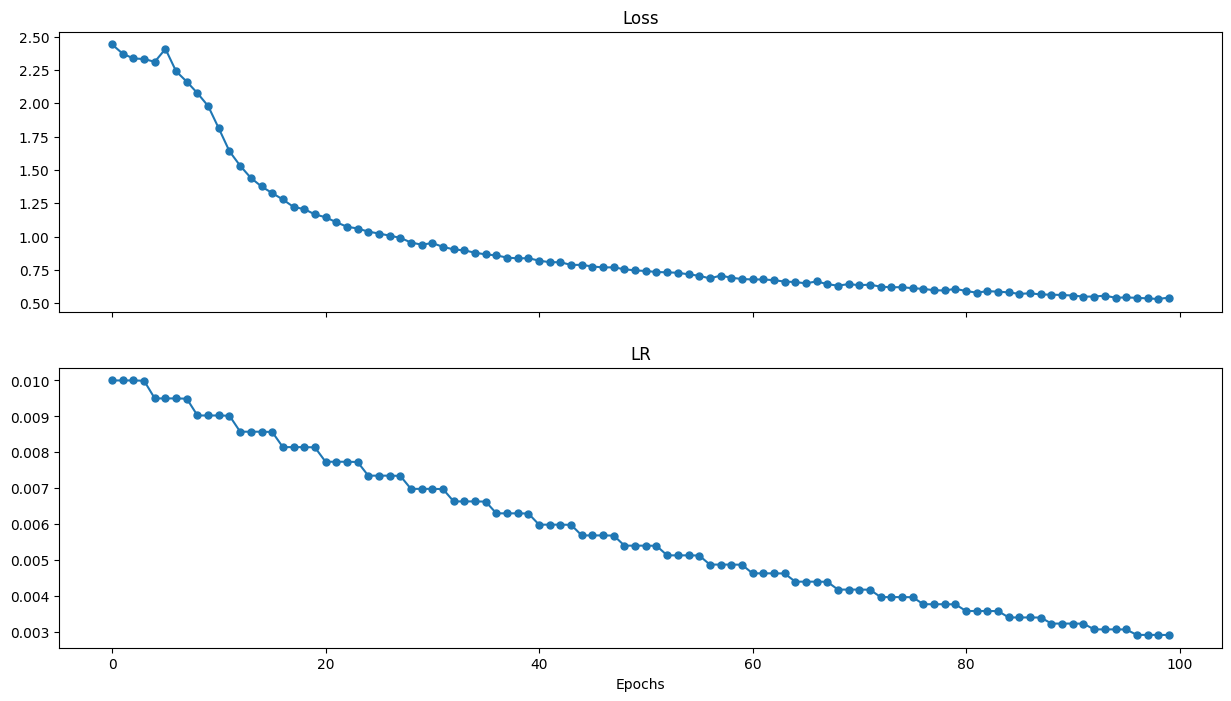

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 8))
ax1.plot(epoch_losses, marker="o", markersize=5)
ax1.set_title("Loss")
ax2.plot(epoch_lrs, marker="o", markersize=5)
ax2.set_title("LR")
plt.xlabel("Epochs")
plt.show()

In [ ]:
path = os.path.join("data", "names", "classifier_model.pth")
torch.save(model.state_dict(), path)

# 10. Run the model on test dataset

In [ ]:
model = Model(input_size=num_chars, output_size=num_langs, hidden_size=hidden_size, num_layers=num_layers)
model = nn.DataParallel(model)
model.load_state_dict(torch.load(path))

<ipython-input-347-e32c3f763109>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


<All keys matched successfully>

In [ ]:
with torch.no_grad():
    Y_train, Y_pred_train = [], []
    for X_mb, Y_mb in tqdm(train_loader):
        out = model(X_mb)
        _, Y_pred_mb = torch.max(out, 1)
        Y_train.extend(Y_mb.numpy().tolist())
        Y_pred_train.extend(Y_pred_mb.cpu().numpy().tolist())

  0%|          | 0/123 [00:00<?, ?it/s]

In [ ]:
with torch.no_grad():
    Y_test, Y_pred_test = [], []
    for X_mb, Y_mb in tqdm(test_loader):
        out = model(X_mb)
        _, Y_pred_mb = torch.max(out, 1)
        Y_test.extend(Y_mb.numpy().tolist())
        Y_pred_test.extend(Y_pred_mb.cpu().numpy().tolist())

  0%|          | 0/980 [00:00<?, ?it/s]

In [ ]:
train_accuracy = accuracy_score(Y_train, Y_pred_train)
test_accuracy = accuracy_score(Y_test, Y_pred_test)
print("Train Accuracy: {}".format(train_accuracy))
print("Test Accuracy: {}".format(test_accuracy))

Train Accuracy: 0.8349601275917066
Test Accuracy: 0.747894871140597


The model performed decently on the test set.

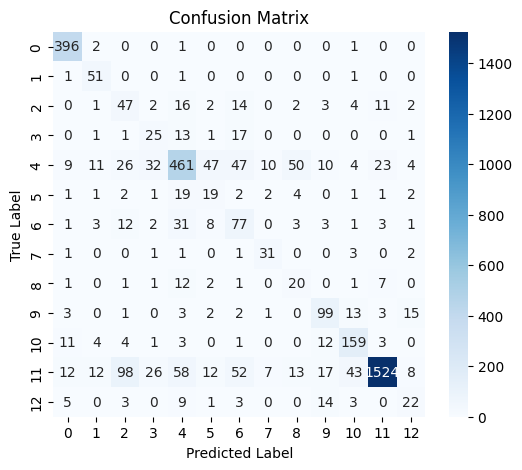

In [ ]:
cm_train = confusion_matrix(Y_train, Y_pred_train)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(Y_train), yticklabels=np.unique(Y_train))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

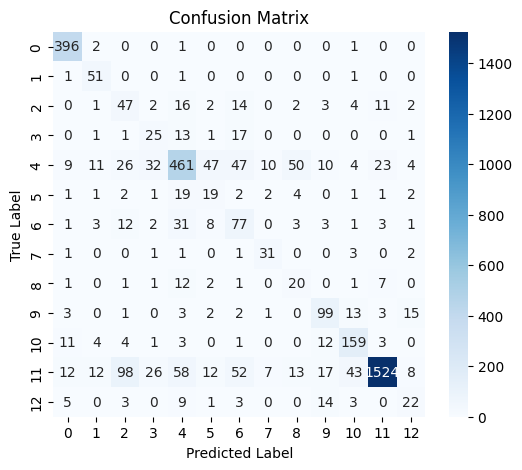

In [ ]:
cm_test = confusion_matrix(Y_test, Y_pred_test)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(Y_train), yticklabels=np.unique(Y_train))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
def compute_accuracies(c_mat):
    accuracies = c_mat.astype('float') / c_mat.sum(axis=1)
    accuracies = accuracies.diagonal()
    accuracies = {k:v for k, v in zip(labels, accuracies)}
    return accuracies
compute_accuracies(cm_train)

{'Arabic': 0.9875,
 'Chinese': 0.9766355140186916,
 'Czech': 0.7542168674698795,
 'Dutch': 0.726890756302521,
 'English': 0.7188139059304703,
 'French': 0.7927927927927928,
 'German': 0.7599309153713298,
 'Greek': 0.9754601226993865,
 'Irish': 0.7849462365591398,
 'Italian': 0.8571428571428571,
 'Japanese': 0.9117276166456494,
 'Russian': 0.8494552218974223,
 'Spanish': 0.7605042016806722}

In [ ]:
compute_accuracies(cm_test)

{'Arabic': 0.99,
 'Chinese': 0.9444444444444444,
 'Czech': 0.4519230769230769,
 'Dutch': 0.423728813559322,
 'English': 0.6280653950953679,
 'French': 0.34545454545454546,
 'German': 0.5310344827586206,
 'Greek': 0.775,
 'Irish': 0.43478260869565216,
 'Italian': 0.6971830985915493,
 'Japanese': 0.803030303030303,
 'Russian': 0.8097768331562167,
 'Spanish': 0.36666666666666664}